In [159]:
# Setup
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchsummary import summary
from PIL import Image
from scipy import optimize
from tabulate import tabulate

In [2]:
# Preprocessing data: convert to tensors and normalize by subtracting dataset
# mean and dividing by std.
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])

# Get data from torchvision.datasets
train_data = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('./data', train=False, download=True, transform=transform)

# Define data loaders used to iterate through dataset
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

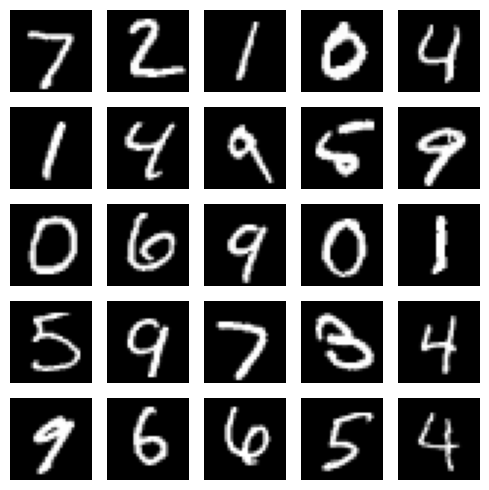

In [3]:
# Show some example images
fig, axs = plt.subplots(5, 5, figsize=(5, 5))
for i in range(25):
    x, _ = test_data[i]
    ax = axs[i // 5][i % 5]
    ax.imshow(x.view(28, 28), cmap='gray')
    ax.axis('off')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [4]:
def try_gpu():
    """
    If GPU is available, return torch.device as cuda:0; else return torch.device
    as cpu.
    """
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

In [5]:
def evaluate_accuracy(data_loader, net, device=torch.device('cpu')):
    """Evaluate accuracy of a model on the given data set."""
    net.eval()  #make sure network is in evaluation mode

    #init
    acc_sum = torch.tensor([0], dtype=torch.float32, device=device)
    n = 0

    for X, y in data_loader:
        # Copy the data to device.
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            y = y.long()
            acc_sum += torch.sum((torch.argmax(net(X), dim=1) == y))
            n += y.shape[0] #increases with the number of samples in the batch
    return acc_sum.item()/n

In [6]:
def training(model, epochs, learning_rate):
#     # Training parameters
#     learning_rate = 0.001
#     epochs = 3

    # Initialize network
    if model == "a":
        net = Net_A()
    elif model == "b":
        net = Net_B()
    elif model == "c":
        net = Net_C()

    summary(net, (1, 28, 28), device='cpu') # (in_channels, height, width)
    optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Define list to store losses and performances of each iteration
    train_losses = []
    train_accs = []
    test_accs = []

    # Try using gpu instead of cpu
    device = try_gpu()

    for epoch in range(epochs):

        # Network in training mode and to device
        net.train()
        net.to(device)

        # Training loop
        for i, (x_batch, y_batch) in enumerate(train_loader):

            # Set to same device
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Set the gradients to zero
            optimizer.zero_grad()

            # Perform forward pass
            y_pred = net(x_batch)

            # Compute the loss
            loss = criterion(y_pred, y_batch)
            train_losses.append(loss)

            # Backward computation and update
            loss.backward()
            optimizer.step()

        # Compute train and test error
        train_acc = 100*evaluate_accuracy(train_loader, net.to('cpu'))
        test_acc = 100*evaluate_accuracy(test_loader, net.to('cpu'))

        # Development of performance
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        # Print performance
        print('Epoch: {:.0f}'.format(epoch+1))
        print('Accuracy of train set: {:.00f}%'.format(train_acc))
        print('Accuracy of test set: {:.00f}%'.format(test_acc))
        print('')


    #fixed error
    losses= [ loss.detach().numpy() for loss in train_losses]

    # Plot training curves
    plt.figure(figsize=(9,4))
    plt.subplot(1,2,1)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.plot(losses)
    plt.grid()

    plt.subplot(1,2,2)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.plot(train_accs, label = 'train')
    plt.plot(test_accs, label = 'test')
    plt.legend()
    plt.grid()

    torch.save(net.state_dict(),f'./model_{model}.pt')

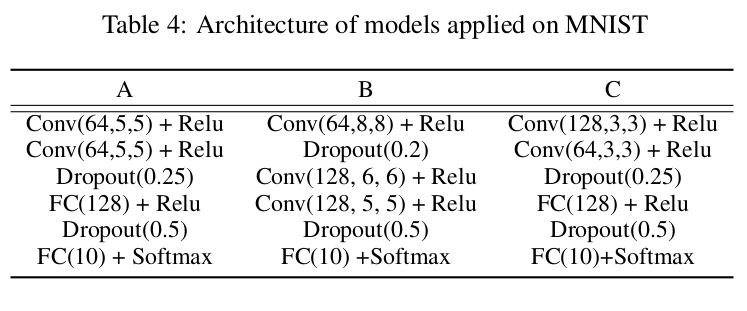

In [7]:
class Net_A(nn.Module):
    """
    Architecture A

    """

    def __init__(self):
        super(Net_A, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 5)
        self.conv2 = nn.Conv2d(64, 64, 5)
        self.dropout1 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(64*20*20, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Conv layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.dropout1(x)
        # Flatten
        x = x.view(-1, 64*20*20)
        # # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.softmax(self.fc2(x), dim=1)

        return x

In [8]:
class Net_B(nn.Module):
    """
    Architecture B

    """

    def __init__(self):
        super(Net_B, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 8)
        self.dropout1 = nn.Dropout2d(0.2)
        self.max_pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(64, 128, 6)
        self.max_pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(128, 128, 5, padding=2)
        self.max_pool3 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(128, 10)

    def forward(self, x):
        # Conv layers
        x = F.relu(self.conv1(x))
        x = self.max_pool1(x)
        x = self.dropout1(x)
        x = F.relu(self.conv2(x))
        x = self.max_pool2(x)
        x = F.relu(self.conv3(x))
        x = self.max_pool3(x)
        x = self.dropout2(x)
        # Flatten
        x = x.view(-1, 128)
        # # Fully connected layers
        x = F.softmax(self.fc1(x), dim=1)
        return x

In [9]:
class Net_C(nn.Module):
    """
    Architecture C

    """

    def __init__(self):
        super(Net_C, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, 3)
        self.max_pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(128, 64, 3)
        self.max_pool2 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(64*5*5, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Conv layers
        x = F.relu(self.conv1(x))
        x = self.max_pool1(x)
        x = F.relu(self.conv2(x))
        x = self.max_pool2(x)
        x = self.dropout1(x)
        # Flatten
        x = x.view(-1, 64*5*5)
        # # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.softmax(self.fc2(x), dim=1)

        return x

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 26, 26]           1,280
         MaxPool2d-2          [-1, 128, 13, 13]               0
            Conv2d-3           [-1, 64, 11, 11]          73,792
         MaxPool2d-4             [-1, 64, 5, 5]               0
         Dropout2d-5             [-1, 64, 5, 5]               0
            Linear-6                  [-1, 128]         204,928
           Dropout-7                  [-1, 128]               0
            Linear-8                   [-1, 10]           1,290
Total params: 281,290
Trainable params: 281,290
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.91
Params size (MB): 1.07
Estimated Total Size (MB): 1.99
----------------------------------------------------------------
Epoch: 1
Accuracy of train set: 28%
Accura

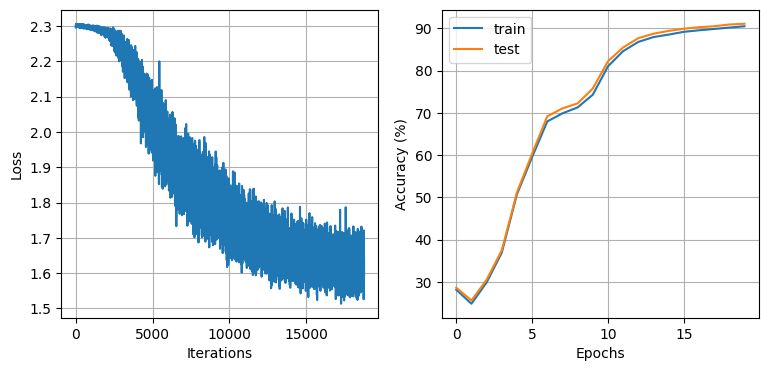

In [37]:
model = "c"
epochs = 20
learning_rate = 0.001

training(model, epochs, learning_rate)

In [10]:
# https://github.com/as791/stAdv-PyTorch/blob/main/StAdv_attack.ipynb - refered code
# https://github.com/rakutentech/stAdv - refered code
def flow_st(images,flows):
    images_shape = images.size()
    flows_shape = flows.size()
    batch_size = images_shape[0]
    H = images_shape[2]
    W = images_shape[3]
    basegrid = torch.stack(torch.meshgrid(torch.arange(0,H), torch.arange(0,W))) #(2,H,W)
    sampling_grid = basegrid.unsqueeze(0).type(torch.float32) + flows
    sampling_grid_x = torch.clamp(sampling_grid[:,1],0.0,W-1.0).type(torch.float32)
    sampling_grid_y = torch.clamp(sampling_grid[:,0],0.0,H-1.0).type(torch.float32)

    x0 = torch.floor(sampling_grid_x).type(torch.int64)
    x1 = x0 + 1
    y0 = torch.floor(sampling_grid_y).type(torch.int64)
    y1 = y0 + 1

    x0 = torch.clamp(x0, 0, W - 2)
    x1 = torch.clamp(x1, 0, W - 1)
    y0 = torch.clamp(y0, 0, H - 2)
    y1 = torch.clamp(y1, 0, H - 1)

    Ia = images[:,:,y0[0,:,:], x0[0,:,:]]
    Ib = images[:,:,y1[0,:,:], x0[0,:,:]]
    Ic = images[:,:,y0[0,:,:], x1[0,:,:]]
    Id = images[:,:,y1[0,:,:], x1[0,:,:]]

    x0 = x0.type(torch.float32)
    x1 = x1.type(torch.float32)
    y0 = y0.type(torch.float32)
    y1 = y1.type(torch.float32)

    wa = (x1 - sampling_grid_x) * (y1 - sampling_grid_y)
    wb = (x1 - sampling_grid_x) * (sampling_grid_y - y0)
    wc = (sampling_grid_x - x0) * (y1 - sampling_grid_y)
    wd = (sampling_grid_x - x0) * (sampling_grid_y - y0)

    perturbed_image = wa.unsqueeze(0)*Ia+wb.unsqueeze(0)*Ib+wc.unsqueeze(0)*Ic+wd.unsqueeze(0)*Id

    return perturbed_image.type(torch.float32)

In [42]:
def flow_loss(flows,padding_mode='constant', epsilon=1e-8):
    paddings = (1,1,1,1)
    padded_flows = F.pad(flows,paddings,mode=padding_mode,value=0)
    shifted_flows = [
        padded_flows[:, :, 2:, 2:],  # bottom right (+1,+1)
        padded_flows[:, :, 2:, :-2],  # bottom left (+1,-1)
        padded_flows[:, :, :-2, 2:],  # top right (-1,+1)
        padded_flows[:, :, :-2, :-2]  # top left (-1,-1)
    ]
    #||\Delta u^{(p)} - \Delta u^{(q)}||_2^2 + # ||\Delta v^{(p)} - \Delta v^{(q)}||_2^2
    loss=0
    for shifted_flow in shifted_flows:
        loss += torch.sum(torch.sqrt(torch.square(flows[:, 1] - shifted_flow[:, 1]) + torch.square(flows[:, 0] - shifted_flow[:, 0])+epsilon))
    return loss.type(torch.float32)

def adv_loss(logits,targets,confidence=0.0):
    confidence=torch.tensor(confidence)
    real = torch.sum(logits*targets,-1)
    other = torch.max((1-targets)*logits-(targets*10000),-1)[0]
    return torch.max(other-real,confidence)[0].type(torch.float32)

In [43]:
def func(flows,input,target,model,const=0.05,confidence=0.0):
    input = torch.from_numpy(input)
    target = torch.from_numpy(target)
    flows = torch.from_numpy(flows).view((1,2,)+input.size()[2:])
    flows.requires_grad=True
    pert_out = flow_st(input,flows)
    output = model(pert_out)
    L_flow = flow_loss(flows)
    L_adv = adv_loss(output,target,confidence)
    L_final = L_adv+const*L_flow
    model.zero_grad()
    L_final.backward()
    gradient = flows.grad.data.view(-1).detach().cpu().numpy()
    return L_final.item(),gradient

In [173]:
def attack(input,target,model,const=0.05,confidence=0.0,init_scale=None):
    if init_scale == None:
        init_flows = np.zeros((1,2,)+input.size()[2:]).reshape(-1)
    else:
        init_flows = init_scale*np.random.randn(*(1,2,)+input.size()[2:]).reshape(-1)
    results = optimize.fmin_l_bfgs_b(func,init_flows,args=(input.cpu().numpy(),target.cpu().numpy(),model,const,confidence))
    if 'CONVERGENCE' in results[2]['task']:
        flows = torch.from_numpy(results[0]).view((1,2,)+input.size()[2:])
        pert_out = flow_st(input,flows)
    else:
        return None
    return pert_out

In [174]:
testset = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
test_loader = torch.utils.data.DataLoader(testset,batch_size=1,shuffle=True)

use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
model = Net_A()
model.load_state_dict(torch.load('./model_a.pt'))
model.eval()

adv = []
adv_label = []
correct_label = []
trgt_label = []
sample = 100
success = 0
for i, data in enumerate(test_loader):
    if i < sample:
        input, label = data[0].to(device), data[1].to(device)
        random_target = np.random.choice([num for num in range(10) if num != label.item()])
        target = torch.from_numpy(np.expand_dims(np.eye(10, dtype=np.float32)[random_target],0))
        pert_out = attack(input,target,model,0.0,0.5)
        if pert_out != None:
            output = model(pert_out)
            adv.append(pert_out.squeeze().detach().cpu().numpy())
            correct_label.append(label.item())
            trgt_label.append(random_target)
            adv_label.append(torch.argmax(output).item())
            if label.item() != torch.argmax(output).item():
                success += 1
    else:
        break

Success Rate: 0.4000 


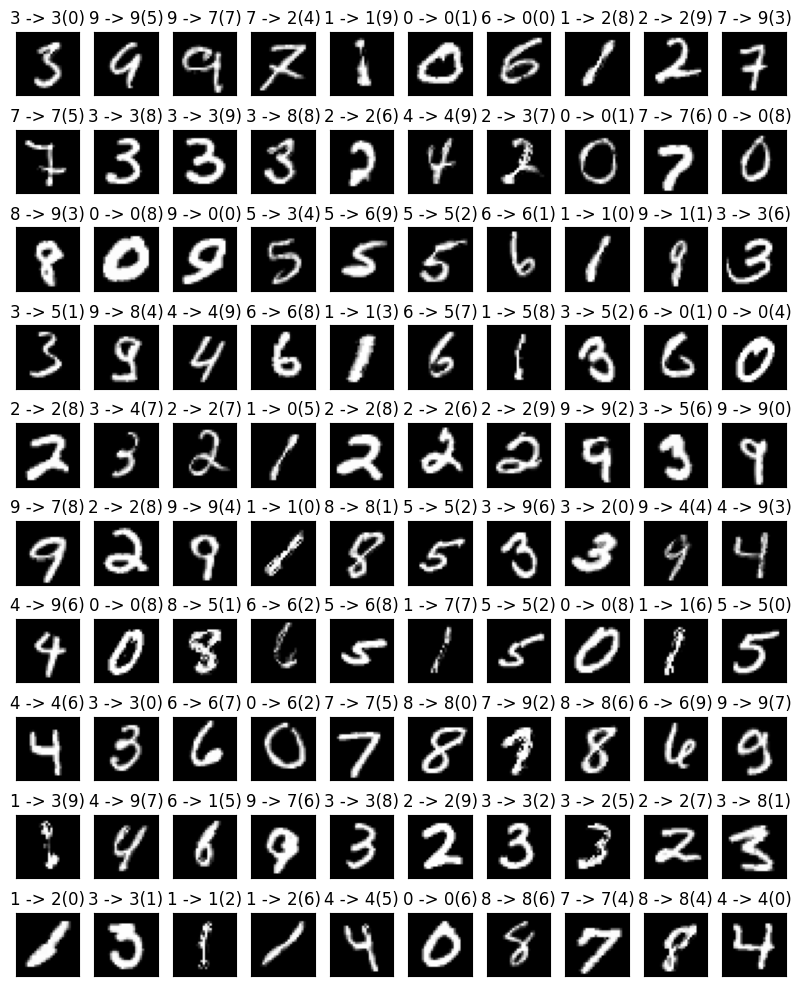

In [175]:
print("Success Rate: {:.4f} ".format(success/sample))
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(adv)):
    cnt += 1
    plt.subplot(10,10,cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    orig,adv_,trgt,ex = correct_label[i],adv_label[i],trgt_label[i],adv[i]
    plt.title("{} -> {}({})".format(orig, adv_, trgt))
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

#### Data and Model Setup

In [190]:
# Function to get a sorted sequence of 10 items with different labels
def get_sorted_sequence(data_loader):
    sorted_sequence = []
    labels_seen = set()

    for data, target in data_loader:
        if len(sorted_sequence) >= 10:
            break

        if target.item() not in labels_seen:
            sorted_sequence.append((data, target.item()))
            labels_seen.add(target.item())

    sorted_sequence.sort(key=lambda x: x[1])

    return sorted_sequence

# Function to construct a dictionary of adversarial examples with the true values on the diagonal
def construct_pert_dict(sorted_sequence, model):
    pert_dict = {}
    for idx, data in enumerate(sorted_sequence):
        seq = []
        for i in range(10):
            target = torch.from_numpy(np.expand_dims(np.eye(10, dtype=np.float32)[i],0))
            if i == data[1]:
                seq.append(data[0])
            else:
                seq.append(attack(data[0],target,model,0.0,0.5))

        pert_dict[data[1]] = seq
    return pert_dict

# Function to plot the dictionary of adversarial examples
def plot_dict_images(image_dict):
    fig, axes = plt.subplots(nrows=len(image_dict), ncols=len(image_dict[0]), figsize=(10, 10))
    fig.suptitle("Target Class")
    for i, (key, image_list) in enumerate(image_dict.items()):
        for j, image in enumerate(image_list):
            if image == None: continue
            axes[i, j].imshow(image.squeeze().detach().cpu().numpy(), cmap='gray')
            axes[i, j].axis('off')
            if i == 0: axes[i, j].set_title(f"{j}")

    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.tight_layout()
    plt.show()

# Function to calculate the adversarial success rate on a number of random samples from the test set
def attack_succes(samples, test_loader, model):
    success = 0
    for i, data in enumerate(test_loader):
        if i < samples:
            input, label = data[0].to(device), data[1].to(device)
            random_target = np.random.choice([num for num in range(10) if num != label.item()])
            target = torch.from_numpy(np.expand_dims(np.eye(10, dtype=np.float32)[random_target],0))
            pert_out = attack(input,target,model,0.0,0.5)
            if pert_out != None:
                output = model(pert_out)
                if label.item() != torch.argmax(output).item():
                    success += 1
        else:
            break
    return success/samples

In [169]:
# Setup the models
model_a = Net_A()
model_a.load_state_dict(torch.load('./model_a.pt'))
model_a.eval()

model_b = Net_B()
model_b.load_state_dict(torch.load('./model_b.pt'))
model_b.eval()

model_c = Net_C()
model_c.load_state_dict(torch.load('./model_c.pt'))
model_c.eval();

In [189]:
# Calculate the model accuracies and the attack success rate
models = [model_a, model_b, model_c]

headers = ["Model", "A", "B", "C"]
test_acc = ["Accuracy (p)"] + [f"{100*evaluate_accuracy(test_loader, net.to('cpu')):.2f}%" for net in models]
attack_suc = ["Attack Success Rate"] + [f"{100*attack_succes(200, test_loader, net.to('cpu')):.2f}%" for net in models]
print(tabulate([test_acc, attack_suc], headers=headers))


Model                A       B       C
-------------------  ------  ------  ------
Accuracy (p)         93.95%  83.04%  91.11%
Attack Success Rate  41.00%  50.50%  53.50%


In [112]:
# Get a sorted sequence of 10 MNIST items

testset = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
test_loader_unshuffled = torch.utils.data.DataLoader(testset,batch_size=1,shuffle=False)

sorted_sequence = get_sorted_sequence(test_loader_unshuffled)

In [191]:
# Generate perturbed examples
pert_dict_a = construct_pert_dict(sorted_sequence, model_a)
pert_dict_b = construct_pert_dict(sorted_sequence, model_b)
pert_dict_c = construct_pert_dict(sorted_sequence, model_c)

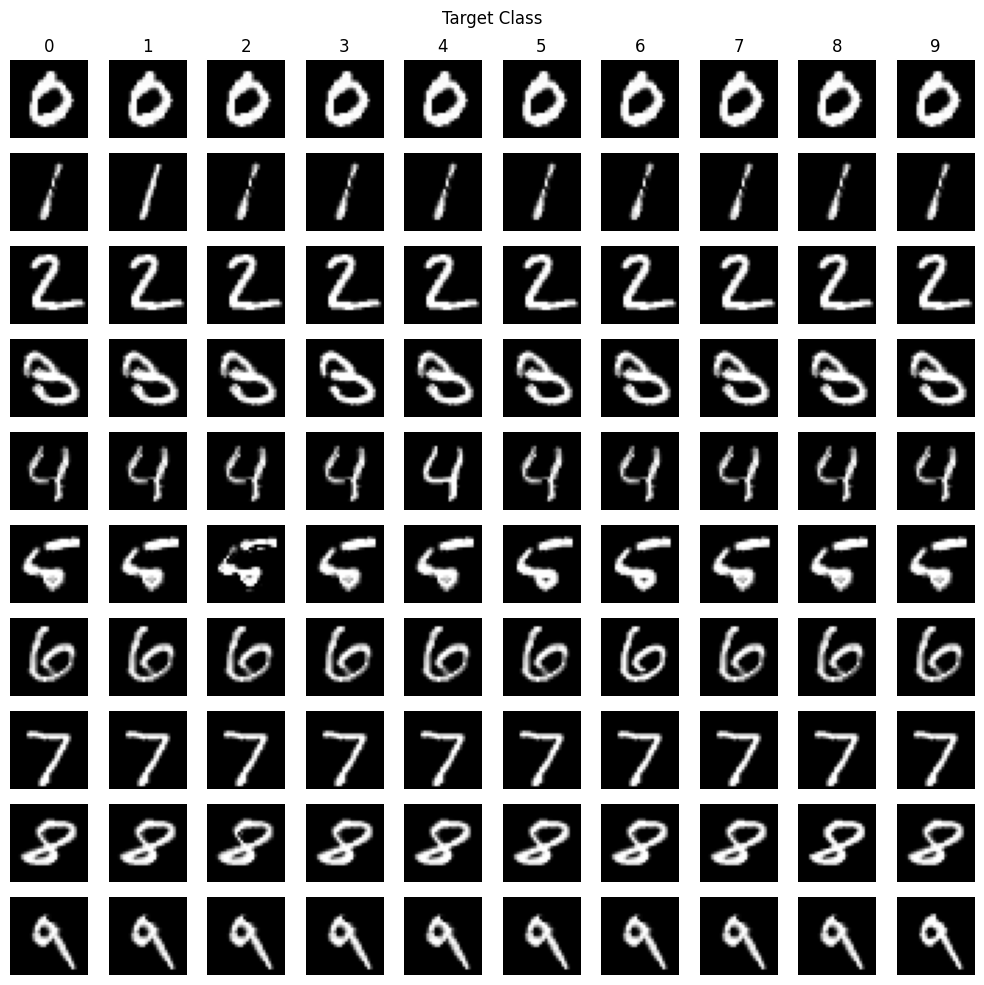

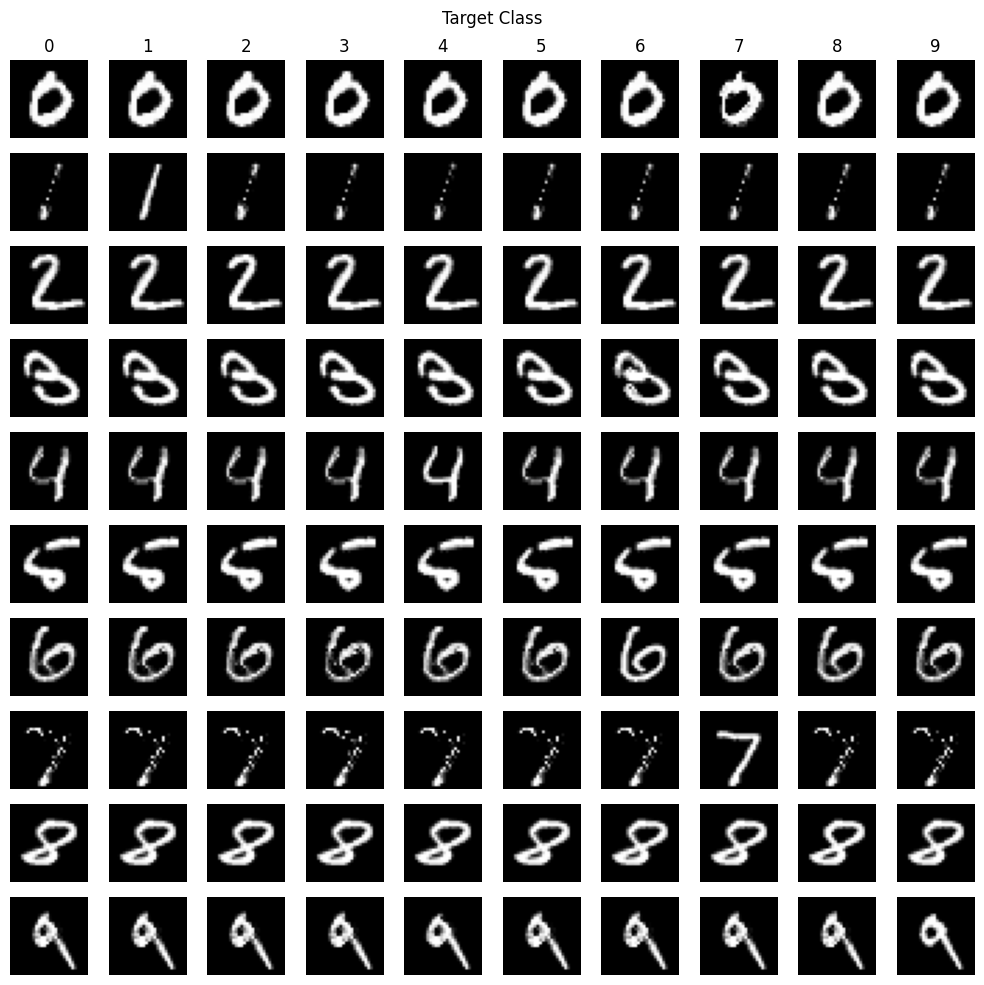

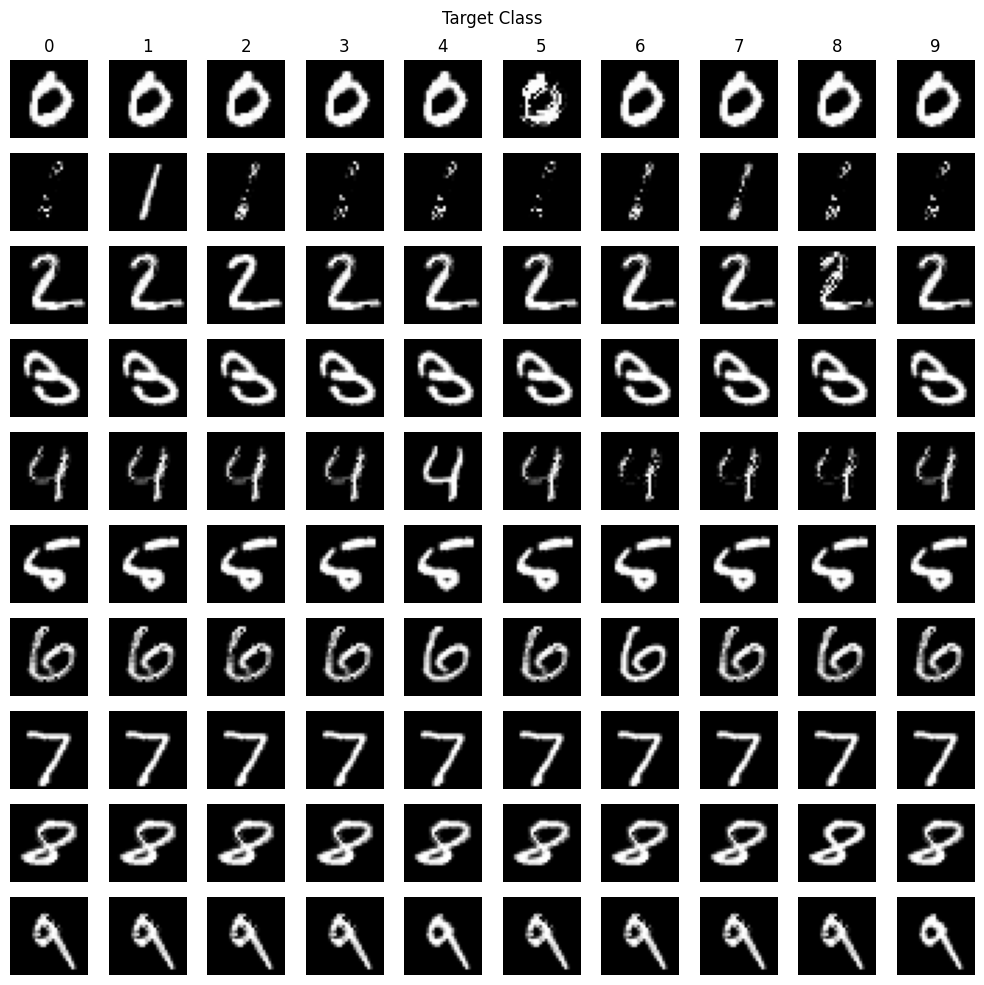

In [195]:
plot_dict_images(pert_dict_a)
plot_dict_images(pert_dict_b)
plot_dict_images(pert_dict_c)
